# Preprocessing of USPTO (Reaxys formatted)

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
from tqdm import trange
# import pyarrow as pa

In [2]:
"""
Disables RDKit whiny logging.
"""
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')


In [3]:
USPTO_elsevier = pd.read_csv('data/USPTO_from_reaxys/uspto_1k_TPL_train_valid.tsv', sep='\t')
USPTO_elsevier.columns

Index(['Unnamed: 0', 'level_0', 'index', 'original_rxn', 'fragments', 'source',
       'year', 'mapped_rxn', 'confidence', 'canonical_rxn_with_fragment_info',
       'canonical_rxn', 'ID', 'reaction_hash', 'reactants', 'products',
       'retro_template', 'template_hash', 'selectivity', 'outcomes',
       'reagents', 'labels'],
      dtype='object')

In [4]:
# USPTO_elsevier = USPTO_elsevier.iloc[:20000]

In [5]:
# create lists for reactants and other stuff
reactant1_list = []
reactant2_list = []

product_list = [] #there's only ever 1 product

reagent1_list = []
reagent2_list = []

other_list = []

for i in range(len(USPTO_elsevier)):
    #handle reactants first
    reactant1 = None
    reactant2 = None
    other = []
    reactants = USPTO_elsevier['reactants'][i].split('.')
    for molecule in reactants:
        if '[' in molecule: #its a reactant
            if not reactant1:
                reactant1 = molecule
            elif not reactant2:
                reactant2 = molecule
            else:
                other +=[molecule]
        else:
            other +=[molecule]

    #then reagents
    reagent1 = None
    reagent2 = None
    reagents = USPTO_elsevier['reagents'][i]
    if reagents == reagents:
        reagents = reagents.split('.')
        for molecule in reagents:
            #populate the first two variables with reagents, add everything else to 'other'
            if 'Pd' in molecule:
                other += [molecule]
            else: 
                if not reagent1:
                    reagent1 = molecule
                elif not reagent2:
                    reagent2 = molecule
                else:
                    other +=[molecule]

    reactant1_list += [reactant1]
    reactant2_list += [reactant2]
    product_list += [USPTO_elsevier['products'][i]]
    reagent1_list += [reagent1]
    reagent2_list += [reagent2]
    other_list += [other]
del USPTO_elsevier

# Read in USPTO data from ORD format (pickled data)

In [6]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm

In [7]:
# mypath = 'data/ORD_USPTO/pickled_data/'
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [8]:
# #create one big df of all the pickled data
# full_df = pd.DataFrame()
# for file in tqdm(onlyfiles):
#     if file[0] != '.': #We don't want to try to unpickle .DS_Store
#         filepath = mypath+file 
#         unpickled_df = pd.read_pickle(filepath)
#         full_df = pd.concat([full_df, unpickled_df], ignore_index=True)


In [9]:
# full_df

# Calculate FP

In [10]:
def calc_fp(lst, radius, nBits):
    ans = []
    for i in tqdm(lst):
        #convert to mole object
        try:
            mol = Chem.MolFromSmiles(i)
            fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits=nBits)
            array = np.zeros((0,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            ans += [array]
        except:
            ans += [np.zeros((nBits,), dtype=int)]
    return ans

In [13]:
# calculate fingerprints
radius = 3
nBits = 256

In [14]:
reactant1_list_fp = calc_fp(reactant1_list, radius, nBits)

100%|██████████| 400604/400604 [01:21<00:00, 4896.47it/s]


In [15]:
from collections import Counter
counter_obj = Counter(reactant1_list)

In [16]:
filter_point = 3
allowed_reactants = {k:v for k,v in counter_obj.items() if v > filter_point}
allowed_reactants = list(allowed_reactants.keys())

In [17]:
allowed_idxes = [idx for idx, i in enumerate(reactant1_list) if i in allowed_reactants]
# takes roughly 3 mins 30

# allowed_idxes = slice(None)

In [18]:
reactant2_list_fp = calc_fp(reactant2_list, radius, nBits)

100%|██████████| 400604/400604 [00:52<00:00, 7621.43it/s]


In [19]:
product_list_fp = calc_fp(product_list, radius, nBits)

100%|██████████| 400604/400604 [01:58<00:00, 3366.85it/s]


In [20]:
#don't actually need to create a fp of the reagent
reagent1_list_fp = calc_fp(reagent1_list, radius, nBits)

100%|██████████| 400604/400604 [00:31<00:00, 12897.17it/s]


In [21]:
#don't actually need to create a fp of the reagent
reagent2_list_fp = calc_fp(reagent2_list, radius, nBits)

100%|██████████| 400604/400604 [00:25<00:00, 15425.00it/s]


In [22]:
# convert to arrays
p = np.array(product_list_fp)[allowed_idxes]
r1 = np.array(reactant1_list_fp)[allowed_idxes]
r2 = np.array(reactant2_list_fp)[allowed_idxes]
rea1 = np.array(reagent1_list_fp)[allowed_idxes]
rea2 = np.array(reagent2_list_fp)[allowed_idxes]
del product_list_fp, reactant1_list_fp, reactant2_list_fp, reagent1_list_fp, reagent2_list_fp

In [23]:
# calculate rxn difference fp
rxn_diff_fp = p - r1 - r2

In [24]:
rxn_diff_fp.shape

(163905, 256)

In [25]:
np.min(np.sum(np.abs(rxn_diff_fp),axis=1))

11

In [26]:
sorted_counter_obj = dict(sorted(counter_obj.items(), key=lambda item: item[1], reverse=True))
counts = pd.Series(list(sorted_counter_obj.values()))

In [27]:
top_n_most_common_reagents = pd.Series(sorted_counter_obj).iloc[:10]
print(f"Count of {filter_point} Most Common Reagents")
top_n_most_common_reagents

Count of 3 Most Common Reagents


CN(C)C(On1nnc2cccnc21)=[N+](C)C                                    7185
CC(=O)O[BH-](OC(C)=O)OC(C)=O                                       5393
O=C([O-])O                                                         4377
[BH4-]                                                             3734
CN(C)C(On1nnc2ccccc21)=[N+](C)C                                    3617
I[CH3:1]                                                           3152
CC(=O)[O-]                                                         2825
CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7]    2805
CC(=O)O[C:2]([CH3:1])=[O:3]                                        2248
[Pd]                                                               2227
dtype: int64

In [28]:
import matplotlib.pyplot as plt

Probability of 3 Most Common Reagents


CN(C)C(On1nnc2cccnc21)=[N+](C)C                                    0.043836
CC(=O)O[BH-](OC(C)=O)OC(C)=O                                       0.032903
O=C([O-])O                                                         0.026704
[BH4-]                                                             0.022781
CN(C)C(On1nnc2ccccc21)=[N+](C)C                                    0.022068
I[CH3:1]                                                           0.019231
CC(=O)[O-]                                                         0.017236
CC(C)(C)OC(=O)O[C:6]([O:5][C:2]([CH3:1])([CH3:3])[CH3:4])=[O:7]    0.017114
CC(=O)O[C:2]([CH3:1])=[O:3]                                        0.013715
[Pd]                                                               0.013587
dtype: float64

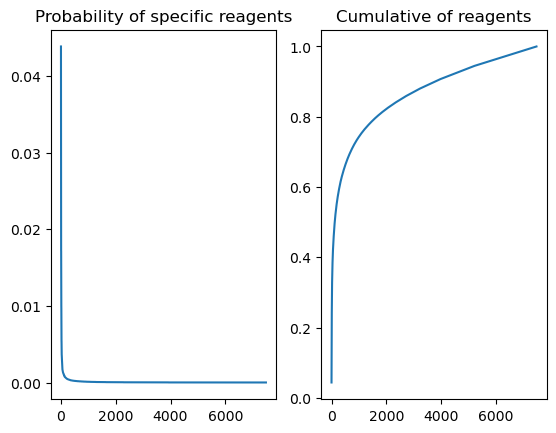

In [29]:
f,ax= plt.subplots(1,2)
(counts[counts > filter_point] / counts[counts > filter_point].sum()).plot(ax=ax[0], title="Probability of specific reagents")
(counts[counts > filter_point].cumsum() / counts[counts > filter_point].sum()).plot(ax=ax[1], title="Cumulative of reagents")
print(f"Probability of {filter_point} Most Common Reagents")
top_n_most_common_reagents / counts[counts > filter_point].sum()

# Clustering

In [30]:
# https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1
# let's use sklearn KMeans
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline

# NN modelling

In [31]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [32]:
# create one-hot encoding of reagent1_list

#start by canonicalising all the reagents
reag1  = []
for idx, smiles in tqdm(enumerate(reagent1_list)):
    if type(allowed_idxes) != slice:   
        if idx not in allowed_idxes:
            continue
    try:
        canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
        reag1 += [canon_smiles]
    except TypeError:
        reag1 += [np.nan]
print(len(set(reag1)))
reag1 = np.array(reag1)

# create one-hot encoding of reagent1_list

# #start by canonicalising all the reagents
# reag2  = []
# for idx, smiles in tqdm(enumerate(reagent2_list)):
#     if type(allowed_idxes) != slice:  
#         if idx not in allowed_idxes:
#             continue
#     try:
#         canon_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))
#         reag2 += [canon_smiles]
#     except TypeError:
#         reag2 += [np.nan]
# print(len(set(reag2)))
# reag2 = np.array(reag2)


reags = reag1 #np.concatenate([reag1, reag2], axis=0)
# Now do the one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
reag_reshaped = reags.reshape(-1, 1)
_ = enc.fit(reag_reshaped)

reag1_ohe = enc.transform(reag1.reshape(-1, 1)).toarray()
# reag2_ohe = enc.transform(reag2.reshape(-1, 1)).toarray()

rxn_diff_fp_train, rxn_diff_fp_val, reag1_ohe_train, reag1_ohe_val = train_test_split(rxn_diff_fp, reag1_ohe, test_size=0.2, random_state=42)

400604it [08:21, 798.50it/s]


1613


In [33]:
e=70
batch_size=0.07
lr=1e-4


In [34]:
import tensorflow

In [35]:
# define the keras model
model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Dense(600, input_shape=(1024,), activation='relu'))
model.add(tensorflow.keras.layers.Dense(600, activation='relu'))
model.add(tensorflow.keras.layers.Dense(reag1_ohe_train.shape[1], activation='linear'))
# compile the keras model
model.compile(loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])

In [36]:
# fit the keras model on the dataset
h = model.fit(rxn_diff_fp_train, reag1_ohe_train, epochs=e, batch_size=int(rxn_diff_fp_train.shape[0] * batch_size), validation_data=(rxn_diff_fp_val, reag1_ohe_val))


Epoch 1/70


ValueError: in user code:

    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Joe_Aspect\miniconda3\envs\cps-env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1024), found shape=(None, 256)


<AxesSubplot:>

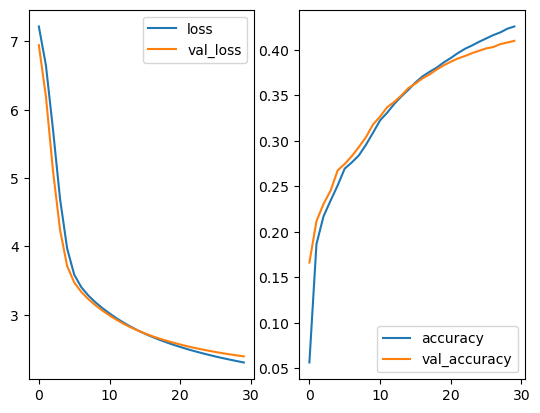

In [ ]:
f,ax = plt.subplots(1,2)
pd.DataFrame(h.history)[['loss', 'val_loss']].plot(ax=ax[0])
pd.DataFrame(h.history)[['accuracy', 'val_accuracy']].plot(ax=ax[1])

## Fully connected

In [ ]:
import torch
import torchmetrics

In [ ]:
Kmean = KMeans(n_clusters=3, verbose=1, max_iter=50, random_state=42)
_ = Kmean.fit(rxn_diff_fp_train)

Initialization complete
Iteration 0, inertia 17805066.0.
Iteration 1, inertia 12421757.716278844.
Iteration 2, inertia 12125325.033771925.
Iteration 3, inertia 12056499.448303713.
Iteration 4, inertia 12003707.367424339.
Iteration 5, inertia 11966715.632509008.
Iteration 6, inertia 11951981.990996698.
Iteration 7, inertia 11948104.081717638.
Iteration 8, inertia 11947379.072140424.
Iteration 9, inertia 11947281.724288708.
Iteration 10, inertia 11947261.685584327.
Iteration 11, inertia 11947254.493119821.
Iteration 12, inertia 11947253.170345511.
Converged at iteration 12: center shift 3.882889945273316e-06 within tolerance 1.1150353186363758e-05.
Initialization complete
Iteration 0, inertia 18144096.0.
Iteration 1, inertia 12460784.862778028.
Iteration 2, inertia 12235266.568634385.
Iteration 3, inertia 12101945.48417821.
Iteration 4, inertia 12068181.621740486.
Iteration 5, inertia 12056961.068683958.
Iteration 6, inertia 12050275.786433334.
Iteration 7, inertia 12046088.106223099.
It

In [ ]:
train_clusters = Kmean.predict(rxn_diff_fp_train)

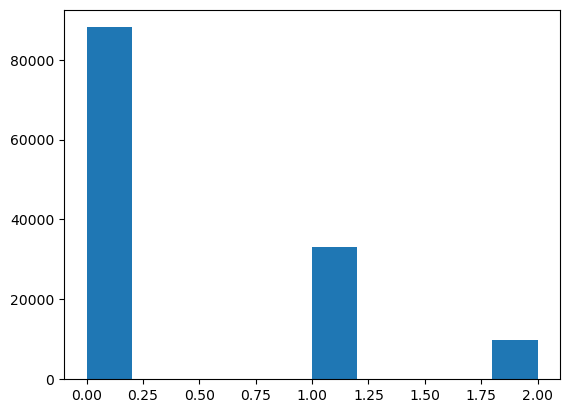

In [ ]:
_ = plt.hist(train_clusters)

In [ ]:
f"num classes = {reag1_ohe_train.shape[1]}"

'num classes = 1613'

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.verbose:
                print(f"Testing my patience {self.counter}/{self.patience}: {validation_loss:.6f} > {self.min_validation_loss + self.min_delta:.6f}")
            if self.counter >= self.patience:
                if self.verbose:
                    print(f"Patience of {self.patience} reached, early stopping")
                return True
        return False


class FullyConnectedReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *, 
        input_dim, 
        hidden_dims, 
        target_dim,
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob
    ):
        super(FullyConnectedReactionModel, self).__init__()
        layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            layers.append(torch.nn.Linear(prev_dim, dim))
            layers.append(hidden_act())
            if use_batchnorm:
                layers.append(torch.nn.BatchNorm1d(dim))
            if dropout_prob > 0:
                layers.append(torch.nn.Dropout(p=dropout_prob))
            prev_dim = dim
        layers.append(torch.nn.Linear(prev_dim, target_dim))
        if output_act is torch.nn.Softmax:
            layers.append(output_act(dim=1))
        else:
            layers.append(output_act())
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x, training=True):

        if training:
            self.train()
        else:
            self.eval()

        return self.layers(x)



def train_loop(model, x_train, y_train, *, epochs, batch_size, loss_fn, optimizer, report_freq, scheduler=None, early_stopper=None, train_cluster_ids_for_downstream=None, train_similarity_dist=None, x_val=None, y_val=None, val_cluster_ids_for_downstream=None, val_similarity_dist=None):
    
    report_epochs = []
    train_loss_trajectory = []
    val_loss_trajectory = []
    train_acc_trajectory = []
    val_acc_trajectory = []
    train_acc_trajectory_top5 = []
    val_acc_trajectory_top5 = []
    train_acc_trajectory_top3 = []
    val_acc_trajectory_top3 = []

    if report_freq and (x_val is not None) and (y_val is not None):
        # if we are reporting the validation data should exist
        if train_cluster_ids_for_downstream is not None:
            assert val_cluster_ids_for_downstream is not None

        if train_similarity_dist is not None:
            assert val_similarity_dist is not None

    acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
    acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
    acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

    
    for e in (t := trange(epochs, desc='', leave=True)):
    # for e in range(epochs):
        idxes = np.arange(x_train.shape[0])
        np.random.shuffle(idxes)

        prev_idx = 0
        interval = int(idxes.shape[0] * batch_size)

        epoch_train_acc = []
        epoch_train_acc_top3 = []
        epoch_train_acc_top5 = []

        for idx in range(interval, idxes.shape[0]+1, interval):
            if batch_size < 1.0:
                batch_idxes = idxes[prev_idx:idx]
            else:
                batch_idxes = idxes
            prev_idx = idx

            if train_cluster_ids_for_downstream is None:
                pred_train = model(x_train[batch_idxes], training=True)
            else:
                pred_train = model(x_train[batch_idxes], train_cluster_ids_for_downstream[batch_idxes], training=True)
            if train_similarity_dist == None:
                loss = loss_fn(pred_train, y_train[batch_idxes])
            else:
                loss = loss_fn(pred_train, y_train[batch_idxes], train_similarity_dist[batch_idxes])
            
            epoch_train_acc.append(acc_metric_top1(pred_train, y_train[batch_idxes].argmax(axis=1)).item())
            epoch_train_acc_top3.append(acc_metric_top3(pred_train, y_train[batch_idxes].argmax(axis=1)).item())
            epoch_train_acc_top5.append(acc_metric_top5(pred_train, y_train[batch_idxes].argmax(axis=1)).item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc_trajectory.append(np.mean(epoch_train_acc))
        train_acc_trajectory_top3.append(np.mean(epoch_train_acc_top3))
        train_acc_trajectory_top5.append(np.mean(epoch_train_acc_top5))
        
        if report_freq:
            if (e % report_freq == 0) or (scheduler is not None) or (early_stopper is not None):
                verbose_str = f"Epoch: {e} Train [ Loss: {loss.detach().numpy().item():.5f} | Acc (Top 1): {train_acc_trajectory[-1]:.5f} | Acc (Top 3): {train_acc_trajectory_top3[-1]:.5f} | Acc (Top 5): {train_acc_trajectory_top5[-1]:.5f}]"
                report_epochs.append(e)
                train_loss_trajectory.append(loss.detach().numpy().item())

                if (x_val is not None) and (y_val is not None):
                    with torch.no_grad():
                        if val_cluster_ids_for_downstream is None:
                            pred_val = model(x_val, training=False)
                        else:
                            pred_val = model(x_val, val_cluster_ids_for_downstream, training=False)
                        if val_similarity_dist == None:
                            loss_val = loss_fn(pred_val, y_val)
                        else:
                            loss_val = loss_fn(pred_val, y_val, val_similarity_dist)
                        

                        val_loss_trajectory.append(loss_val.detach().numpy().item())
                        val_acc = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory.append(val_acc)
                        val_acc_top5 = acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory_top5.append(val_acc_top5)
                        val_acc_top3 = acc_metric_top3(pred_val, y_val.argmax(axis=1)).item()
                        val_acc_trajectory_top3.append(val_acc_top3)
                        verbose_str += f"\t Validation [ Loss: {loss_val.detach().numpy().item():.5f} | Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]"
                        if scheduler is not None:
                            scheduler.step(loss_val)
                        if early_stopper is not None:
                            if early_stopper.early_stop(loss_val):             
                                break
                # print(verbose_str)
                
                t.set_description(verbose_str, refresh=True)

    train_traj = {
        ("train","loss"): train_loss_trajectory, ("train","acc"): train_acc_trajectory,  ("train","acc_top3"): train_acc_trajectory_top3, ("train","acc_top5"): train_acc_trajectory_top5
    }

    if val_loss_trajectory:
        val_traj = {
            ("val","loss"): val_loss_trajectory, ("val","acc"): val_acc_trajectory, ("val","acc_top3"): val_acc_trajectory_top3, ("val","acc_top5"): val_acc_trajectory_top5
        }
        return pd.DataFrame({**train_traj, **val_traj}, index=report_epochs)
    else:
        return pd.DataFrame(train_traj, index=report_epochs)


In [ ]:
# A data through one model for all reactions
# rxn_diff_fp width -> ohe width

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
fcrm = FullyConnectedReactionModel(
    input_dim=x_train.shape[1],
    hidden_dims=[600, 600],
    target_dim=y_train.shape[1],
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.Identity, 
    use_batchnorm=True, 
    dropout_prob=0.2,
)

optimizer = torch.optim.Adam(fcrm.parameters(), lr=lr)
scheduler = None  # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
early_stopper = None  # EarlyStopper(patience=50, min_delta=0, verbose=True)

hist = train_loop(fcrm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=optimizer, report_freq=1, x_val=x_val, y_val=y_val, scheduler=scheduler, early_stopper=early_stopper)

In [ ]:
x_train = torch.Tensor(rxn_diff_fp_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_train = torch.Tensor(reag1_ohe_train)
y_val = torch.Tensor(reag1_ohe_val)

pred_train = fcrm(x_train, training=False)
pred_val = fcrm(x_val, training=False)

acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

train_acc, train_acc_top3, train_acc_top5 = acc_metric_top1(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top3(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top5(pred_train, y_train.argmax(axis=1)).item()
val_acc, val_acc_top3, val_acc_top5 = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top3(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()

print(f"Train      [ Acc (Top 1): {train_acc:.5f} | Acc (Top 3): {train_acc_top3:.5f} | Acc (Top 5): {train_acc_top5: .5f}]")
print(f"Validation [ Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]")

Train      [ Acc (Top 1): 0.76379 | Acc (Top 3): 0.90976 | Acc (Top 5):  0.94688]
Validation [ Acc (Top 1): 0.47787 | Acc (Top 3): 0.71679 | Acc (Top 5):  0.79589]


Text(0.5, 0.98, 'All Data')

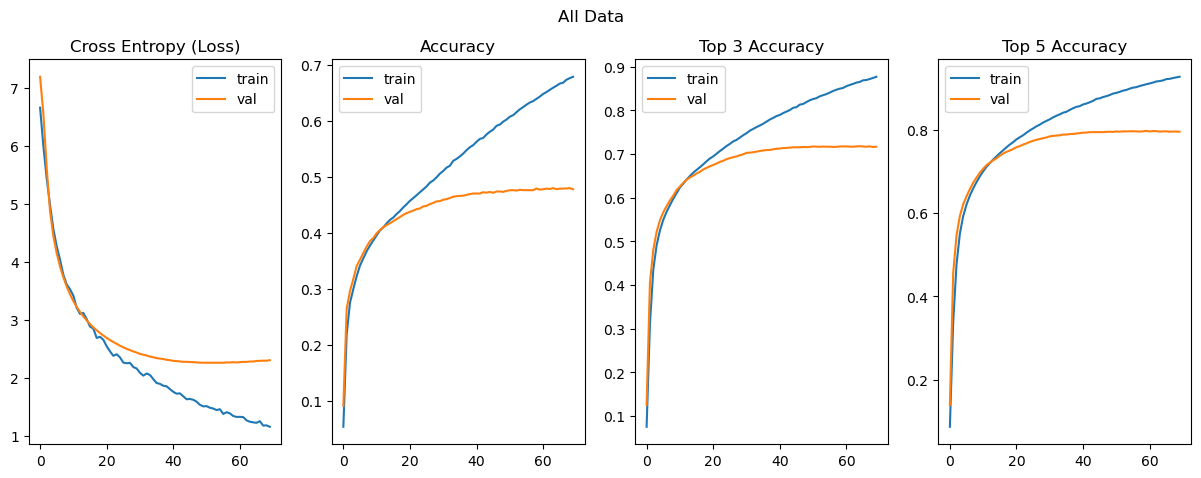

In [ ]:
f,ax=plt.subplots(1,4, figsize=(15, 5))
hist.loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title="Cross Entropy (Loss)", ax=ax[0])
hist.loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title="Accuracy", ax=ax[1])
hist.loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
hist.loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
f.suptitle("All Data")

In [ ]:
# Data through one model per reaction cluster
# rxn_diff_fp width -> ohe width

train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)

cluster_models = {}
cluster_histories = {}

for cluster in np.unique(train_clusters):
    print(cluster)
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    y_train = torch.Tensor(reag1_ohe_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    y_val = torch.Tensor(reag1_ohe_val[val_clusters == cluster])
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[600,600],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Identity, 
        use_batchnorm=True, 
        dropout_prob=0.2,
    )

    optimizer=torch.optim.Adam(fcrm.parameters(), lr=lr)
    scheduler = None#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
    early_stopper = None#EarlyStopper(patience=50, min_delta=0, verbose=True)

    hist = train_loop(fcrm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=optimizer, report_freq=1, x_val=x_val, y_val=y_val, scheduler=scheduler, early_stopper=early_stopper)
    cluster_models[cluster] = fcrm
    cluster_histories[cluster] = hist

In [ ]:
y_train = torch.Tensor(reag1_ohe_train)
y_val = torch.Tensor(reag1_ohe_val)
pred_train = torch.zeros_like(y_train)
pred_val = torch.zeros_like(y_val)
for cluster in np.unique(train_clusters):
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    cluster_pred_train = cluster_models[cluster](x_train, training=False)
    cluster_pred_val = cluster_models[cluster](x_val, training=False)
    pred_train[train_clusters == cluster] = cluster_pred_train
    pred_val[val_clusters == cluster] = cluster_pred_val

acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

train_acc, train_acc_top3, train_acc_top5 = acc_metric_top1(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top3(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top5(pred_train, y_train.argmax(axis=1)).item()
val_acc, val_acc_top3, val_acc_top5 = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top3(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()

print(f"Train      [ Acc (Top 1): {train_acc:.5f} | Acc (Top 3): {train_acc_top3:.5f} | Acc (Top 5): {train_acc_top5: .5f}]")
print(f"Validation [ Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]")

Train      [ Acc (Top 1): 0.63212 | Acc (Top 3): 0.81675 | Acc (Top 5):  0.87504]
Validation [ Acc (Top 1): 0.46615 | Acc (Top 3): 0.70193 | Acc (Top 5):  0.77975]


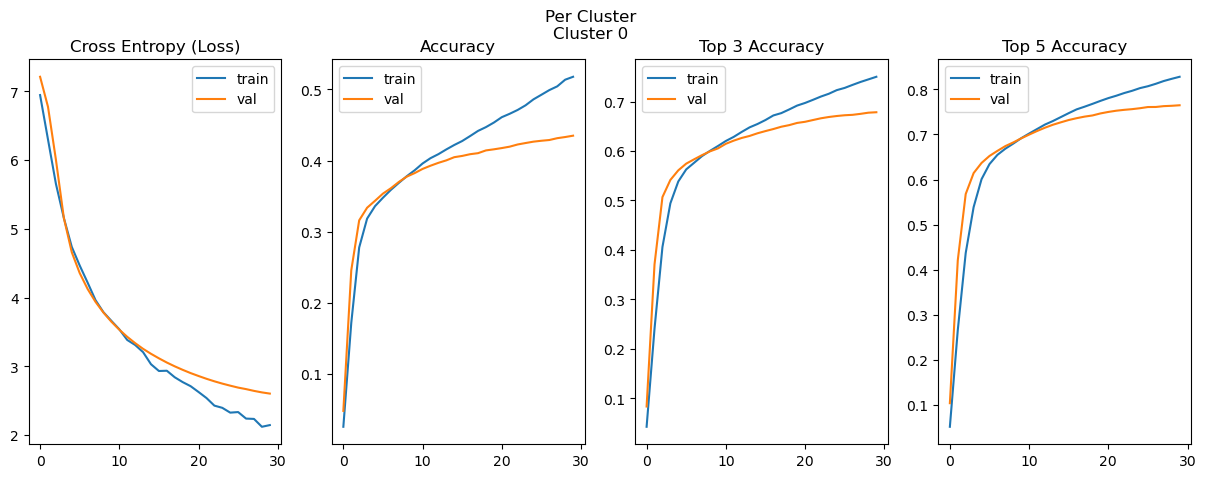

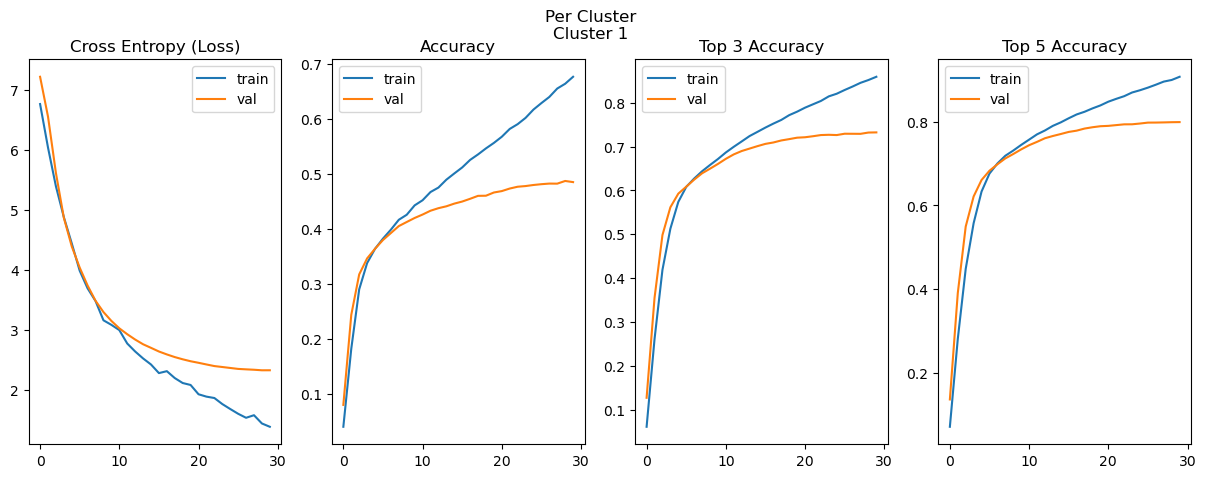

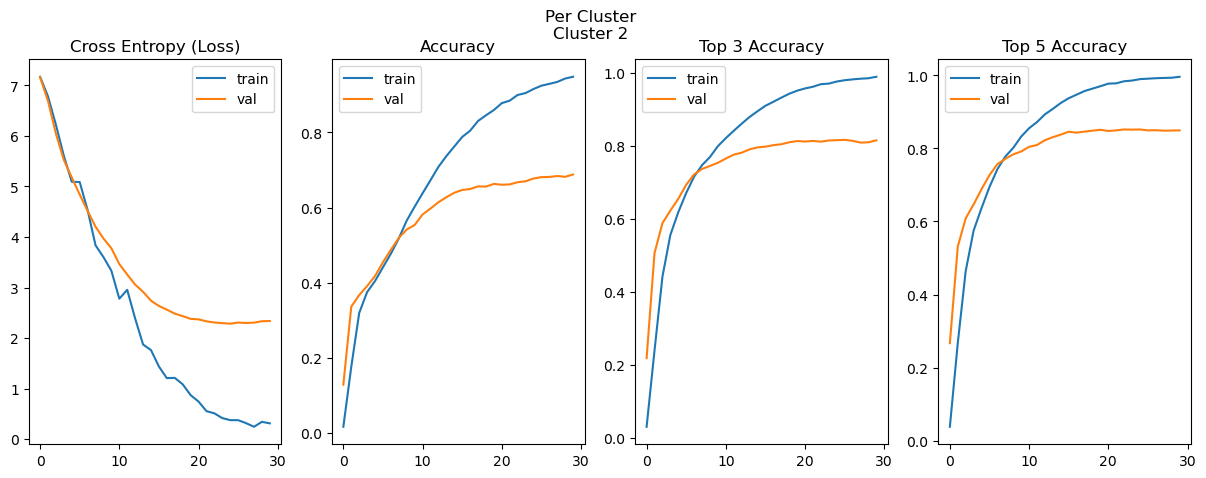

In [ ]:
for cluster in np.unique(train_clusters):   
    f,ax=plt.subplots(1,4, figsize=(15, 5))
    cluster_histories[cluster].loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title=f"Cross Entropy (Loss)", ax=ax[0])
    cluster_histories[cluster].loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title=f"Accuracy", ax=ax[1])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title=f"Top 3 Accuracy", ax=ax[2])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title=f"Top 5 Accuracy", ax=ax[3])
    f.suptitle(f"Per Cluster\nCluster {cluster}")
    plt.show()

In [ ]:
# Shared upstream layers but then downstream they become cluster specific

# we can either have the model train the clusters at the same time or one after the other (in single epoch steps)
# TODO I am unsure how the gradient graph will be built if trained at the same time

class SharedUpstreamReactionModel(torch.nn.Module):

    def __init__(
        self, 
        *,
        num_clusters, 
        input_dim, 
        hidden_dims,
        target_dim, 
        hidden_act, 
        output_act, 
        use_batchnorm, 
        dropout_prob,
        downstream_input_dim,
        downstream_hidden_dims,
        downstream_hidden_act, 
        downstream_output_act, 
        downstream_use_batchnorm, 
        downstream_dropout_prob,
    ):
        super(SharedUpstreamReactionModel, self).__init__()

        self.target_dim = target_dim

        self.shared_upstream = FullyConnectedReactionModel(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            target_dim=downstream_input_dim,
            hidden_act=hidden_act, 
            output_act=output_act, 
            use_batchnorm=use_batchnorm, 
            dropout_prob=dropout_prob,
        )

        self.downstream_models = {}
        for c in range(num_clusters):
            self.downstream_models[c] = FullyConnectedReactionModel(
                input_dim=downstream_input_dim,
                hidden_dims=downstream_hidden_dims,
                target_dim=target_dim,
                hidden_act=downstream_hidden_act, 
                output_act=downstream_output_act, 
                use_batchnorm=downstream_use_batchnorm, 
                dropout_prob=downstream_dropout_prob,
            )

    def forward(self, x, cluster_ids, training=True):
        shared_output = self.shared_upstream(x, training=training)
        output = torch.zeros(shared_output.shape[0], self.target_dim)

        for c in np.unique(cluster_ids):
            cluster_model_output = self.downstream_models[c](shared_output[cluster_ids == c], training=training)
            output[cluster_ids == c] = cluster_model_output
        return output

In [ ]:
train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)
x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)


surm = SharedUpstreamReactionModel(
    num_clusters=len(np.unique(train_clusters)), 
    input_dim=x_train.shape[1], 
    hidden_dims=[600,600],
    target_dim=y_train.shape[1], 
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.ReLU, 
    use_batchnorm=True, 
    dropout_prob=0.2,
    downstream_input_dim=1000,
    downstream_hidden_dims=[600,600],
    downstream_hidden_act=torch.nn.ReLU, 
    downstream_output_act=torch.nn.Identity, 
    downstream_use_batchnorm=True, 
    downstream_dropout_prob=0.2,
)

optimizer=torch.optim.Adam(surm.parameters(), lr=lr)
scheduler = None  #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
early_stopper = None  #EarlyStopper(patience=50, min_delta=0, verbose=True)

hist = train_loop(surm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=optimizer, report_freq=1, train_cluster_ids_for_downstream=train_clusters, x_val=x_val, y_val=y_val, val_cluster_ids_for_downstream=val_clusters, scheduler=scheduler, early_stopper=early_stopper)

In [ ]:
x_train = torch.Tensor(rxn_diff_fp_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_train = torch.Tensor(reag1_ohe_train)
y_val = torch.Tensor(reag1_ohe_val)
train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)

pred_train = surm(x_train, cluster_ids=train_clusters, training=False)
pred_val = surm(x_val, cluster_ids=val_clusters, training=False)

acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

train_acc, train_acc_top3, train_acc_top5 = acc_metric_top1(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top3(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top5(pred_train, y_train.argmax(axis=1)).item()
val_acc, val_acc_top3, val_acc_top5 = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top3(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()

print(f"Train      [ Acc (Top 1): {train_acc:.5f} | Acc (Top 3): {train_acc_top3:.5f} | Acc (Top 5): {train_acc_top5: .5f}]")
print(f"Validation [ Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]")

Train      [ Acc (Top 1): 0.57865 | Acc (Top 3): 0.72383 | Acc (Top 5):  0.74520]
Validation [ Acc (Top 1): 0.45526 | Acc (Top 3): 0.61954 | Acc (Top 5):  0.64217]


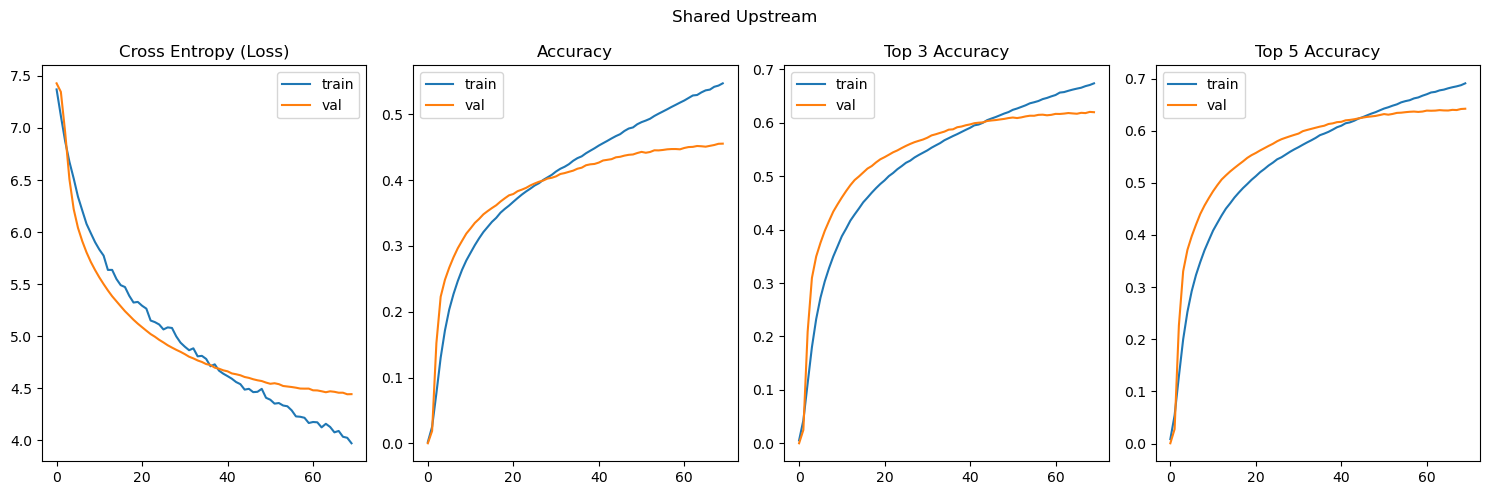

In [ ]:
f,ax=plt.subplots(1, 4, figsize=(15, 5))
hist.loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title="Cross Entropy (Loss)", ax=ax[0])
hist.loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title="Accuracy", ax=ax[1])
hist.loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
hist.loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
f.suptitle("Shared Upstream")
plt.tight_layout()

In [ ]:
# Data through one model per reaction cluster but we scale the gradient based on the distance to the cluster, this is not parameter sharing but is infact a form of label smoothing

# rxn_diff_fp width -> ohe width
# we end up here with 10 valid models so we can either ensemble or just predict based on the which cluster is most near

In [ ]:
def similarity_CrossEntropyLoss(y_pred, y_true, dist):
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    return torch.mean(loss_fn(y_pred, y_true) * dist)

cluster_models = {}
cluster_histories = {}

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(reag1_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(reag1_ohe_val)
train_dist = torch.nn.Softmax(dim=1)(torch.Tensor(-1 * Kmean.transform(rxn_diff_fp_train)))
val_dist = torch.nn.Softmax(dim=1)(torch.Tensor(-1 * Kmean.transform(rxn_diff_fp_val)))

for cluster in np.unique(train_clusters):
    print(cluster)
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[600,600],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Identity, 
        use_batchnorm=True, 
        dropout_prob=0.2,
    )
    cluster_models[cluster] = fcrm

    optimizer = torch.optim.Adam(fcrm.parameters(), lr=lr)
    scheduler = None#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
    early_stopper = None#EarlyStopper(patience=50, min_delta=0, verbose=True)
    
    hist = train_loop(fcrm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=similarity_CrossEntropyLoss, optimizer=optimizer, report_freq=1, train_similarity_dist=train_dist[:, cluster], x_val=x_val, y_val=y_val, val_similarity_dist=val_dist[:, cluster], scheduler=scheduler, early_stopper=early_stopper)
    cluster_histories[cluster] = hist

0


1


2


In [ ]:
y_train = torch.Tensor(reag1_ohe_train)
y_val = torch.Tensor(reag1_ohe_val)
pred_train = torch.zeros_like(y_train)
pred_val = torch.zeros_like(y_val)
for cluster in np.unique(train_clusters):
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    cluster_pred_train = cluster_models[cluster](x_train, training=False)
    cluster_pred_val = cluster_models[cluster](x_val, training=False)
    pred_train[train_clusters == cluster] = cluster_pred_train
    pred_val[val_clusters == cluster] = cluster_pred_val

acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

train_acc, train_acc_top3, train_acc_top5 = acc_metric_top1(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top3(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top5(pred_train, y_train.argmax(axis=1)).item()
val_acc, val_acc_top3, val_acc_top5 = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top3(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()

print(f"Train      [ Acc (Top 1): {train_acc:.5f} | Acc (Top 3): {train_acc_top3:.5f} | Acc (Top 5): {train_acc_top5: .5f}]")
print(f"Validation [ Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]")

Train      [ Acc (Top 1): 0.84090 | Acc (Top 3): 0.94626 | Acc (Top 5):  0.97021]
Validation [ Acc (Top 1): 0.48906 | Acc (Top 3): 0.71850 | Acc (Top 5):  0.79738]


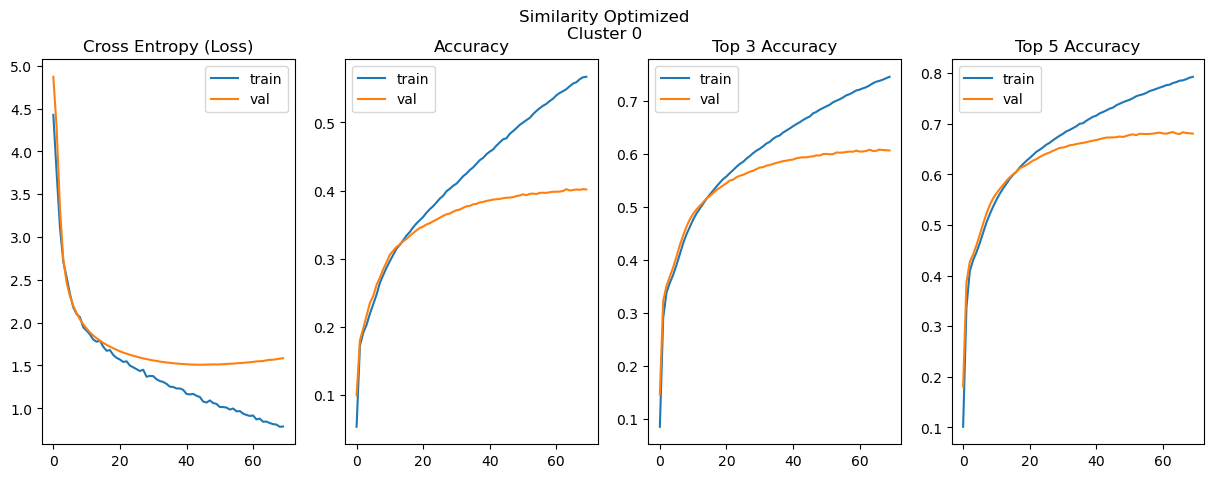

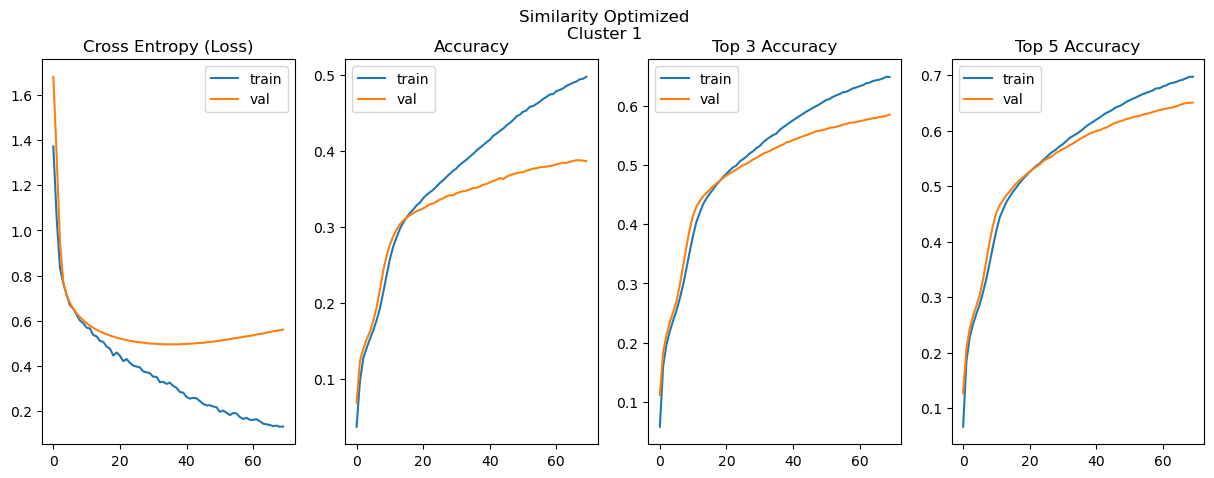

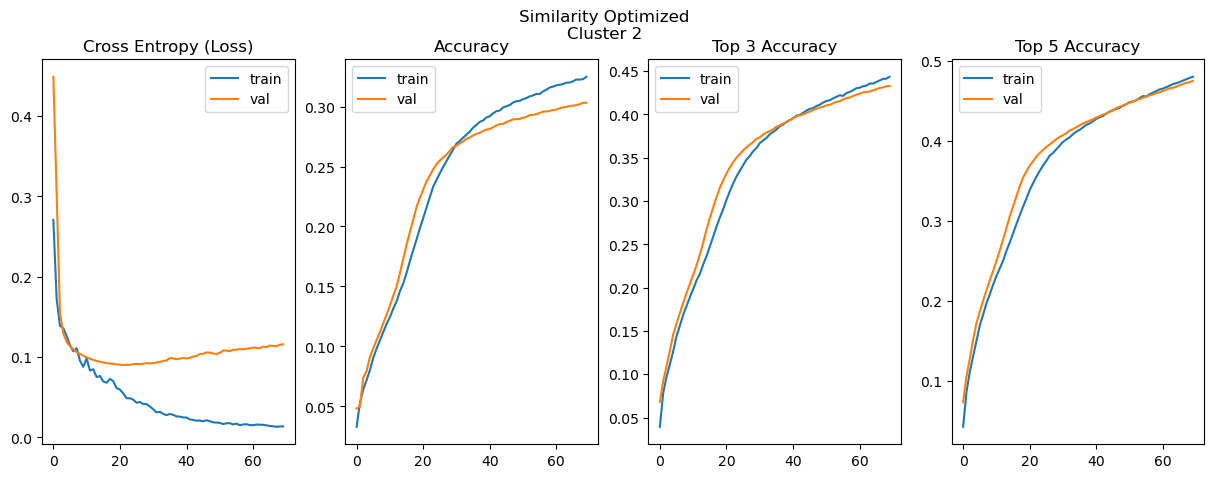

In [ ]:
for cluster in np.unique(train_clusters):   
    f,ax=plt.subplots(1, 4, figsize=(15, 5))
    cluster_histories[cluster].loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title=f"Cross Entropy (Loss)", ax=ax[0])
    cluster_histories[cluster].loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title=f"Accuracy", ax=ax[1])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
    cluster_histories[cluster].loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
    f.suptitle(f"Similarity Optimized\nCluster {cluster}")
    plt.show()

In [ ]:
# there are two ways we can do prediction here.

# we can either just assume the clustering method is mostly right and then take the model that it is assigned to as the one that does the prediction
# or we can assume that the clustering method is a bias but isnt necessarily correct. Therefore, we should consider the prediction from all the models and scale the certainty of the prediction by the distance from the cluster centre. 

# why?

# the first method works well if clusters are very far apart with no overlap and also very little misclassification of the cluster.
# if the cluster is misclassified then we end up with the situation where the choosen model might be very uncertain and wrong but another cluster might be more certain and correct.


# 526,000 total
# 100,000 are unclassified (failed reactions or compound purchases). Can these be used for training or not? Regardless we can validate on these reactions.
#  14,000 have 2 clusters
#     450 have 3 clusters
#      15 have 4 clusters

# there are 12 clusters

# as a feature we can provide the top 3
# monte carlo tree search to choose the most likely

# we should be able to output no reagents used

# train with a set of reagent 1 and reagent 2
# if your prediction for reagent 2 is reagent 1 then it is also correct
# a single one hot encoding that includes reagent 2 is a good idea

# adversarial training where we add in the unknowns as a option during trajectory prediction

In [ ]:
# we might want to see how the accuracy for the clusters data compared to the whole datasets data 

# if clustering data >> all data: the model is fine tuned for the cluster
# if clustering data ~ all data: the model isnt fine tuned on the clusters data and if the cluster performance has converged then the clustering doesnt provide much or any benefit.
# if clustering data << all data: I am unsure why this would occur. Unless all data is small and clustering data is very small (in which case the model just isnt learning anything)

```
Old results:

Single MLP

Train      [ Acc (Top 1): 0.16173 | Acc (Top 3): 0.40805 | Acc (Top 5):  0.61869]
Validation [ Acc (Top 1): 0.15143 | Acc (Top 3): 0.38761 | Acc (Top 5):  0.58492]

MLP per Cluster

Train      [ Acc (Top 1): 0.20418 | Acc (Top 3): 0.47007 | Acc (Top 5):  0.63013]
Validation [ Acc (Top 1): 0.19712 | Acc (Top 3): 0.44969 | Acc (Top 5):  0.59400]

Shared Upstream Model

Train      [ Acc (Top 1): 0.80727 | Acc (Top 3): 0.88917 | Acc (Top 5):  0.90648]
Validation [ Acc (Top 1): 0.43078 | Acc (Top 3): 0.51576 | Acc (Top 5):  0.53810]

Scaling Training by Cluster Distance

Train      [ Acc (Top 1): 0.10988 | Acc (Top 3): 0.18575 | Acc (Top 5):  0.28047]
Validation [ Acc (Top 1): 0.10461 | Acc (Top 3): 0.17934 | Acc (Top 5):  0.26975]

---

New Results:

30 epochs, lr = 1e-4, dropout = 0.2, batchnorm = True, batch size = 0.07

Single MLP

Train      [ Acc (Top 1): 0.53648 | Acc (Top 3): 0.76085 | Acc (Top 5):  0.83465]
Validation [ Acc (Top 1): 0.45578 | Acc (Top 3): 0.69723 | Acc (Top 5):  0.78167]

MLP per Cluster

Train      [ Acc (Top 1): 0.63212 | Acc (Top 3): 0.81675 | Acc (Top 5):  0.87504]
Validation [ Acc (Top 1): 0.46615 | Acc (Top 3): 0.70193 | Acc (Top 5):  0.77975]

Shared Upstream Model

Train      [ Acc (Top 1): 0.43177 | Acc (Top 3): 0.59526 | Acc (Top 5):  0.61777]
Validation [ Acc (Top 1): 0.40432 | Acc (Top 3): 0.56643 | Acc (Top 5):  0.58567]

Scaling Training by Cluster Distance

Train      [ Acc (Top 1): 0.60559 | Acc (Top 3): 0.80741 | Acc (Top 5):  0.87394]
Validation [ Acc (Top 1): 0.47427 | Acc (Top 3): 0.71807 | Acc (Top 5):  0.80538]
```